In [22]:
import numpy as np
import scipy.stats as st
from matplotlib import pyplot as plt
import sys
sys.path.append("../")
import os
from tqdm import tqdm_notebook

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
import matplotlib
matplotlib.style.use('classic')
import pickle as pkl


from finite import curves_one_stage
from finite import greedy, dp, beta, get_data

In [23]:
param = {
    'sigmag': np.array([0.2, 0.2]),
    'pg': np.array([0.4, 0.6]),
}

In [24]:
def dU(alpha, mu, sigmat, p):
    ppf = st.norm.ppf(1-alpha)
    return p[0] / alpha * (ppf * (sigmat[0] - sigmat[1]))

def U(alpha, mu, sigmat, p):
    ppf = st.norm.ppf(1-alpha)
    return mu + st.norm.pdf(ppf)/alpha * np.sum(sigmat * p)
    
def upper_bound(alpha, mu, sigmat, p):
    return 1. - alpha * dU(alpha, mu, sigmat, p) / U(alpha, mu, sigmat, p)

def upper_bound2(alpha, mu, sigmat, p):
    return 1. + (1 - alpha) * dU(alpha, mu, sigmat, p) / U(alpha, mu, sigmat, p)

In [25]:
n=10000
T=1
pot = st.beta(2,5)

a1s = np.arange(0.01, 1.01, 0.01)
facts = [15]
for fact in facts:
    res = {'gr': [], 'dp': [], 'opt': []}
    param['sigmag'][0] = param['sigmag'][1] * fact
    for t in range(T):
        data = get_data(n, param, potential=pot)
        q, x, g = data
        res['gr'].append(curves_one_stage(data,  a1s, T=T, alg=greedy))
        xtilde = []
        for i in tqdm_notebook(range(len(x))):
            h = np.arange(0, 1, 0.0001)
            num = np.sum(h * st.norm(x[i],param['sigmag'][1-g[i]]).pdf(h)*pot.pdf(h))
            den = np.sum(st.norm(x[i],param['sigmag'][1-g[i]]).pdf(h)*pot.pdf(h))
            xtilde.append(num / den)
        new_data = (q, np.array(xtilde), g)
        res['opt'].append(curves_one_stage(new_data,  a1s, T=T, alg=greedy))
        res['dp'].append(curves_one_stage(data,  a1s, T=T, alg=dp))

    res['gr'] = np.array(res['gr'])
    res['dp'] = np.array(res['dp'])
    res['opt'] = np.array(res['opt'])
    with open("./data/beta/beta-{}-{}-{}.pkl".format(1, n, fact), 'wb') as f:
        pkl.dump(res, f)

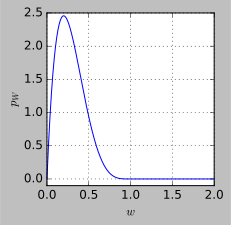

In [26]:
plt.figure(figsize=(3,3))

x = np.arange(0, 2, 0.0001)
plt.plot(x, pot.pdf(x), color='blue')
plt.ylim(-0.1, 2.5)
plt.xlim(0, 2)
plt.xlabel("$w$")
plt.ylabel("$p_W$", rotation=90)
plt.grid()
# plt.savefig("../fig/beta_pdf.pdf", bbox_inches='tight')

# Figures

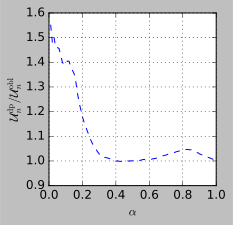

In [27]:
plt.figure(figsize=(3,3))
lw=1
color = ['r', 'g', 'b', 'k']
ls = ['-', '--', '-.', ':']
for i, fact in enumerate(facts):
    with open("./data/beta/beta-{}-{}-{}.pkl".format(1, n, fact), 'rb') as f:
        res = pkl.load(f)
    plt.plot(np.array(res['dp'][0,0,:]), (np.array(res['dp'][:,1,:])/np.array(res['gr'][:,1,:])).mean(axis=0), \
             ls='--', color='blue', lw=lw, label="$\\sigma_A / \\sigma_B={}$".format(fact))

plt.xlabel("$\\alpha$")
plt.ylabel("$\mathcal{U}_n^\mathrm{dp}/\mathcal{U}_n^\mathrm{obl}$", rotation=90)
plt.grid()

# plt.savefig("../fig/beta-dp-obl.pdf", bbox_inches='tight')

In [28]:
mu = pot.mean()
sigma = np.array([pot.std(), pot.std()])
sigmag = param['sigmag']
bounds = upper_bound(a1s, mu, sigma / np.sqrt(sigmag**2 + sigma**2), param['pg'])
bounds2 = upper_bound2(a1s, mu, sigma / np.sqrt(sigmag**2 + sigma**2), param['pg'])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]


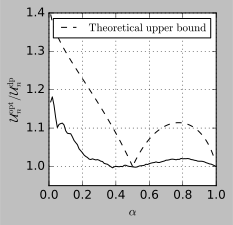

In [29]:
plt.figure(figsize=(3,3))
lw=1
color = ['r', 'g', 'b', 'k']
ls = ['-', '--', '-.', ':']
for i, fact in enumerate(facts):
    with open("./data/beta/beta-{}-{}-{}.pkl".format(1, n, fact), 'rb') as f:
        res = pkl.load(f)
    plt.plot(np.array(res['dp'][0,0,:]), (np.array(res['opt'][:,1,:])/np.array(res['dp'][:,1,:])).mean(axis=0), \
             ls='-', color='k', lw=lw)

plt.xlabel("$\\alpha$")
plt.ylabel("$\mathcal{U}_n^\mathrm{opt}/\mathcal{U}_n^\mathrm{dp}$", rotation=90)
plt.plot(a1s[:50], bounds[:50], 'k--')
plt.plot(a1s[50:], bounds2[50:], 'k--', label='$\mathrm{Theoretical\ upper\ bound}$')

plt.legend(fontsize=11, loc='upper right')
plt.grid()

# plt.savefig("../fig/beta-opt-dp.pdf", bbox_inches='tight')

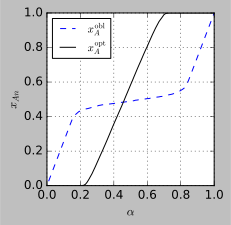

In [30]:
plt.figure(figsize=(3,3))
lw=1
color = ['r', 'g', 'b', 'k']
ls = ['-', '--', '-.', ':']
for i, fact in enumerate(facts):
    with open("./data/beta/beta-{}-{}-{}.pkl".format(1, n, fact), 'rb') as f:
        res = pkl.load(f)
    plt.plot(np.array(res['dp'][0,0,:]), (np.array(res['gr'][:,2,:])).mean(axis=0), \
             ls='--', color='b', lw=lw, label="$x_A^\mathrm{obl}$")
    plt.plot(np.array(res['dp'][0,0,:]), (np.array(res['opt'][:,2,:])).mean(axis=0), \
             ls='-', color='k', lw=lw, label="$x_A^\mathrm{opt}$")
plt.xlabel("$\\alpha$")
plt.ylabel("$x_{An}$", rotation=90)

plt.legend(fontsize=11, loc='upper left')
plt.grid()

# plt.savefig("../fig/beta-x.pdf", bbox_inches='tight')